In [1]:
from datetime import datetime
import xarray as xr
myPath = '/Users/leguillou/WORK/Developpement/'
import sys
sys.path.insert(0,myPath+'toolbox/')
sys.path.insert(0,myPath+'toolbox/xscale/')
import xscale
import numpy as np
import netCDF4 as nc
import xscale.spectral.fft as xfft
from matplotlib.colors import LogNorm
import cmocean
import matplotlib.pylab as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

import Wavenum_freq_spec_func as wfs

/Users/leguillou/anaconda3/lib/python3.7/site-packages/xarray/core/merge.py:10: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  PANDAS_TYPES = (pd.Series, pd.DataFrame, pd.Panel)


In [2]:
myPath = '/Users/leguillou/WORK/Developpement/'
dir_data =  myPath + "DATA/eNATL60/merged_outputs/hourly/"
file_data = 'eNATL60_GULFSTREAM_SSH.1h_y2009m07d01_y2010m06d30_degraded20_timeFiltered.nc'

In [20]:
init_date = datetime(2009,8,1,0)
final_date = datetime(2009,10,1,0)

In [29]:
ds = xr.open_mfdataset(dir_data+file_data)
print(ds)
times = ds['time'][:]
lon = ds['nav_lon'][:,:] % 360
lat = ds['nav_lat'][:,:]

<xarray.Dataset>
Dimensions:                     (time: 8736, x: 205, y: 257)
Coordinates:
  * time                        (time) datetime64[ns] 2009-07-01T12:28:48 ... 2010-06-30T11:29:04
Dimensions without coordinates: x, y
Data variables:
    nav_lon                     (y, x) float32 dask.array<shape=(257, 205), chunksize=(257, 205)>
    nav_lat                     (y, x) float32 dask.array<shape=(257, 205), chunksize=(257, 205)>
    degraded_sossheig_filtered  (time, y, x) float32 dask.array<shape=(8736, 257, 205), chunksize=(8736, 257, 205)>
    degraded_sossheig           (time, y, x) float32 dask.array<shape=(8736, 257, 205), chunksize=(8736, 257, 205)>


In [22]:
tmin = (init_date-datetime(1900,1,1,0)).total_seconds()
tmax = (final_date-datetime(1900,1,1,0)).total_seconds()
indt = np.where((times>=np.datetime64(init_date))&(times<=np.datetime64(final_date)))[0]

In [23]:
times = times[indt]
ssh = ds['degraded_sossheig'][indt,:,:]
ssh_filt = ds['degraded_sossheig_filtered'][indt,:,:]

In [18]:
dx,dy = wfs.get_dx_dy(ssh[0],lon,lat)
SSHtide_No_NaN = ssh.interpolate_na(dim='y')
SSHtide_dtr = wfs.detrendn(SSHtide_No_NaN,axes=[0,1,2])
SSHtide_wdw = wfs.apply_window(SSHtide_dtr, SSHtide_dtr.dims, window_type='hanning')
SSHtidehat = xfft.fft(SSHtide_wdw, dim=('time', 'x', 'y'), dx={'x': dx, 'y': dx}, sym=True)
SSHtide_psd = xfft.psd(SSHtidehat)
SSHtide_frequency,kx,ky = wfs.get_f_kx_ky_flo(SSHtidehat)
SSHtide_wavenumber,kradial = wfs.get_wavnum_kradial(kx,ky)
SSHtide_psd_np = SSHtide_psd.values
SSHtide_wavenum_freq_spectrum = wfs.get_f_k_in_2D(kradial,SSHtide_wavenumber,SSHtide_psd_np)
 

/Users/leguillou/anaconda3/lib/python3.7/site-packages/dask/array/blockwise.py:241: UserWarning: The da.atop function has moved to da.blockwise
  warnings.warn("The da.atop function has moved to da.blockwise")


0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400


In [24]:
dx,dy = wfs.get_dx_dy(ssh_filt[0],lon,lat)
SSHfilt_No_NaN = ssh_filt.interpolate_na(dim='y')
SSHfilt_dtr = wfs.detrendn(SSHfilt_No_NaN,axes=[0,1,2])
SSHfilt_wdw = wfs.apply_window(SSHfilt_dtr, SSHfilt_dtr.dims, window_type='hanning')
SSHfilthat = xfft.fft(SSHfilt_wdw, dim=('time', 'x', 'y'), dx={'x': dx, 'y': dx}, sym=True)
SSHfilt_psd = xfft.psd(SSHfilthat)
SSHfilt_frequency,kx,ky = wfs.get_f_kx_ky_flo(SSHfilthat)
SSHfilt_wavenumber,kradial = wfs.get_wavnum_kradial(kx,ky)
SSHfilt_psd_np = SSHfilt_psd.values
SSHfilt_wavenum_freq_spectrum = wfs.get_f_k_in_2D(kradial,SSHfilt_wavenumber,SSHfilt_psd_np)

/Users/leguillou/anaconda3/lib/python3.7/site-packages/dask/array/blockwise.py:241: UserWarning: The da.atop function has moved to da.blockwise
  warnings.warn("The da.atop function has moved to da.blockwise")


0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400


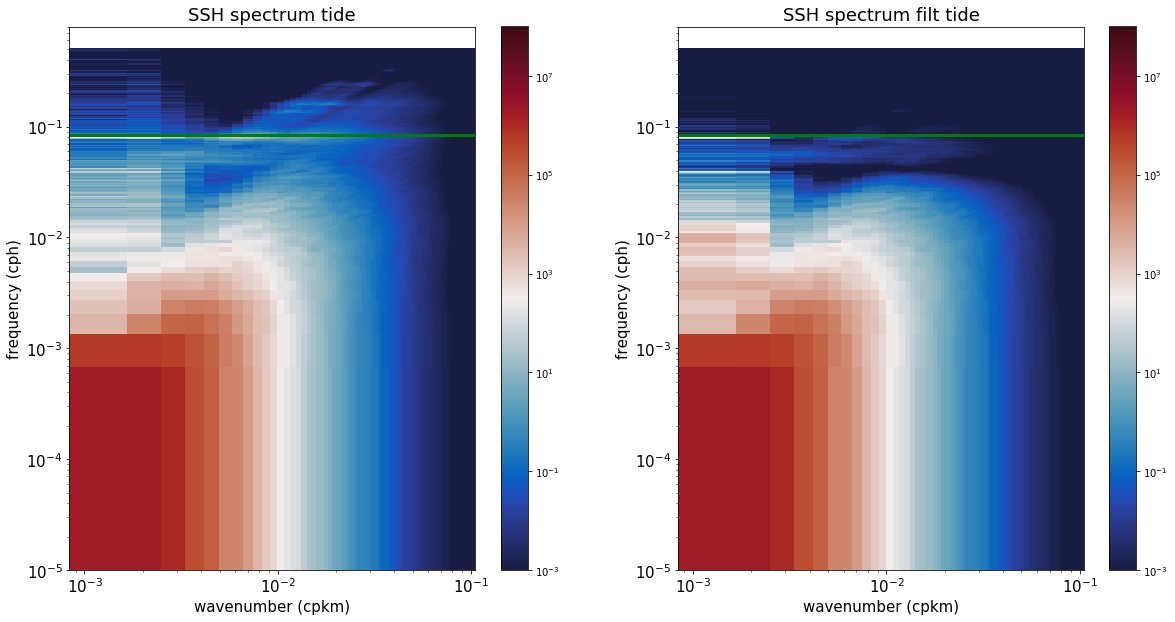

In [32]:
sec_to_hour = 3600.0
T=12

norm = LogNorm(vmin=0.001,vmax=1e8)
cmap = cmocean.cm.balance

fig=plt.figure(figsize=(20,10))

ax = plt.subplot(121)
plt.pcolormesh(SSHtide_wavenumber,sec_to_hour*SSHtide_frequency,SSHtide_wavenum_freq_spectrum,norm=norm,cmap=cmap) 
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel('wavenumber (cpkm)',fontsize=15)
ax.set_ylabel('frequency (cph)',fontsize=15)
ax.set_xlim(SSHtide_wavenumber.min(),SSHtide_wavenumber.max())
ax.set_ylim(1E-5,8E-1)
plt.axhline(y=1/T,color='g', linewidth=3)
ax.set_title('SSH spectrum tide',size=18)
ax.tick_params(labelsize=15)
plt.colorbar()


ax = plt.subplot(122)
plt.pcolormesh(SSHfilt_wavenumber,sec_to_hour*SSHfilt_frequency,SSHfilt_wavenum_freq_spectrum,norm=norm,cmap=cmap)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel('wavenumber (cpkm)',fontsize=15)
ax.set_ylabel('frequency (cph)',fontsize=15)
ax.set_xlim(SSHtidefilt_wavenumber.min(),SSHtidefilt_wavenumber.max())
ax.set_ylim(1E-5,8E-1)
plt.axhline(y=1/T,color='g', linewidth=3)
ax.set_title('SSH spectrum filt tide',size=18)
ax.tick_params(labelsize=15)
plt.colorbar()
